# Advanced Dropout Regularization: Preventing Overfitting in Deep Networks

In [7]:
import torch  # Import PyTorch for neural network operations
import torch.nn as nn  # Import neural network modules from PyTorch
import torch.nn.functional as F  # Import functional interface for neural network operations
import matplotlib.pyplot as plt  # Import matplotlib for plotting and visualization
import numpy as np  # Import numpy for numerical operations
from matplotlib.colors import ListedColormap  # Import colormap for visualization
from torch.utils.data import Dataset, DataLoader  # Import data handling utilities
from SpiralDataSet import SpiralData  # Import our custom spiral dataset

torch.manual_seed(42)  # Ensure reproducible results across experiments

# GPU/CPU device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set device for computation
print(f"Using device: {device}")  # Display selected device
if device.type == 'cuda':  # If using GPU
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")  # Display GPU name
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")  # Display GPU memory

Using device: cuda
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU
GPU Memory: 4.0 GB


In [8]:
# =============================================================================
# Nonlinear Dataset Class for Dropout Experimentation
# =============================================================================

class NonlinearData(Dataset):  # Custom dataset class for nonlinear classification
    """Generate nonlinear dataset to test dropout effectiveness"""
    
    def __init__(self, N_SAMPLES=1000, noise_std=0.15, train=True):  # Constructor with sample control
        """
        Create nonlinear dataset with polynomial decision boundary
        Args:
            N_SAMPLES: Number of samples to generate
            noise_std: Standard deviation of noise
            train: Whether this is training data (affects random seed)
        """
        # Define polynomial coefficients for decision boundary
        a = np.matrix([-1, 1, 2, 1, 1, -3, 1]).T  # Polynomial coefficients
        
        # Generate random 2D points
        self.x = np.matrix(np.random.rand(N_SAMPLES, 2))  # Random 2D points
        
        # Create polynomial decision function
        self.f = np.array(a[0] + (self.x) * a[1:3] + 
                         np.multiply(self.x[:, 0], self.x[:, 1]) * a[4] + 
                         np.multiply(self.x, self.x) * a[5:7]).flatten()  # Polynomial function
        
        self.a = a  # Store coefficients
        
        # Create binary labels based on polynomial
        self.y = np.zeros(N_SAMPLES)  # Initialize labels
        self.y[self.f > 0] = 1  # Positive class where function > 0
        
        # Convert to PyTorch tensors
        self.y = torch.from_numpy(self.y).type(torch.LongTensor)  # Labels as long tensor
        self.x = torch.from_numpy(self.x).type(torch.FloatTensor)  # Features as float tensor
        self.f = torch.from_numpy(self.f)  # Decision function values
        
        # Add noise for realistic data
        if train == True:  # Training data noise
            torch.manual_seed(1)  # Set seed for reproducible noise
            self.x = self.x + noise_std * torch.randn(self.x.size())  # Add noise
            torch.manual_seed(0)  # Reset seed
        else:  # Validation data noise
            self.x = self.x + noise_std * torch.randn(self.x.size())  # Add different noise
        
        self.len = N_SAMPLES  # Store dataset length
    
    def __getitem__(self, index):  # Get single sample
        """Return feature-label pair for given index"""
        return self.x[index], self.y[index]  # Return data point
    
    def __len__(self):  # Get dataset length
        """Return total number of samples"""
        return self.len  # Return dataset size
    
    def plot_data(self):  # Visualize the dataset
        """Plot the nonlinear dataset with true decision boundary"""
        X = self.x.numpy()  # Convert to numpy for plotting
        y = self.y.numpy()  # Convert labels to numpy
        
        # Create mesh grid for decision boundary
        h = 0.02  # Step size
        x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1  # X bounds
        y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1  # Y bounds
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))  # Create grid
        
        # Calculate true decision boundary
        Z = self.multi_dim_poly(np.c_[xx.ravel(), yy.ravel()]).flatten()  # Evaluate polynomial
        f = np.zeros(Z.shape)  # Initialize boundary
        f[Z > 0] = 1  # Set positive regions
        f = f.reshape(xx.shape)  # Reshape to grid
        
        plt.figure(figsize=(10, 8))  # Set figure size
        plt.title('Nonlinear Dataset with True Decision Boundary', fontsize=14)  # Add title
        
        # Plot data points
        plt.plot(self.x[self.y == 0, 0].numpy(), self.x[self.y == 0, 1].numpy(), 
                'bo', markersize=8, label='Class 0', alpha=0.7)  # Class 0 points
        plt.plot(self.x[self.y == 1, 0].numpy(), self.x[self.y == 1, 1].numpy(), 
                'ro', markersize=8, label='Class 1', alpha=0.7)  # Class 1 points
        
        # Plot decision boundary
        plt.contour(xx, yy, f, colors='black', linewidths=2, linestyles='--')  # Decision boundary
        plt.xlim(0, 1)  # Set x limits
        plt.ylim(0, 1)  # Set y limits
        plt.xlabel("Feature 1", fontsize=12)  # X-axis label
        plt.ylabel("Feature 2", fontsize=12)  # Y-axis label
        plt.legend(fontsize=12)  # Add legend
        plt.grid(True, alpha=0.3)  # Add grid
        plt.show()  # Display plot
    
    def multi_dim_poly(self, x):  # Polynomial decision function
        """Calculate polynomial decision function for given points"""
        x = np.matrix(x)  # Convert to matrix
        out = np.array(self.a[0] + (x) * self.a[1:3] + 
                      np.multiply(x[:, 0], x[:, 1]) * self.a[4] + 
                      np.multiply(x, x) * self.a[5:7])  # Calculate polynomial
        out = np.array(out)  # Convert to array
        return out  # Return polynomial values

In [9]:
# =============================================================================
# Advanced Neural Network with Configurable Dropout
# =============================================================================

class DropoutNet(nn.Module):  # Neural network with dropout regularization
    """Deep neural network with configurable dropout for overfitting prevention"""
    
    def __init__(self, input_size, hidden_sizes, output_size, dropout_probs=None):  # Constructor with flexible architecture
        """
        Initialize network with configurable dropout
        Args:
            input_size: Number of input features
            hidden_sizes: List of hidden layer sizes
            output_size: Number of output classes
            dropout_probs: List of dropout probabilities for each layer (None for no dropout)
        """
        super(DropoutNet, self).__init__()  # Initialize parent class
        
        self.num_layers = len(hidden_sizes)  # Number of hidden layers
        self.dropout_probs = dropout_probs if dropout_probs else [0.0] * self.num_layers  # Default no dropout
        
        # Create layer lists
        self.layers = nn.ModuleList()  # Linear layers
        self.dropouts = nn.ModuleList()  # Dropout layers
        
        # Input to first hidden layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))  # First layer
        self.dropouts.append(nn.Dropout(p=self.dropout_probs[0]))  # First dropout
        
        # Hidden layer to hidden layer
        for i in range(1, len(hidden_sizes)):  # Iterate through hidden layers
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))  # Add layer
            self.dropouts.append(nn.Dropout(p=self.dropout_probs[i] if i < len(self.dropout_probs) else 0.0))  # Add dropout
        
        # Last hidden to output
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)  # Output layer
        
        self.architecture_info = {  # Store architecture information
            'input_size': input_size,
            'hidden_sizes': hidden_sizes,
            'output_size': output_size,
            'dropout_probs': self.dropout_probs
        }
    
    def forward(self, x):  # Forward pass through network
        """Forward pass with dropout applied during training"""
        activation = x  # Initialize with input
        
        # Pass through hidden layers
        for i in range(self.num_layers):  # Iterate through layers
            activation = self.layers[i](activation)  # Linear transformation
            activation = F.relu(activation)  # ReLU activation
            activation = self.dropouts[i](activation)  # Apply dropout
        
        # Output layer (no activation for logits)
        output = self.output_layer(activation)  # Final linear transformation
        return output  # Return predictions
    
    def get_architecture_summary(self):  # Method to display architecture
        """Display detailed architecture information"""
        print(f"=== Network Architecture Summary ===")
        print(f"Input Size: {self.architecture_info['input_size']}")
        print(f"Hidden Layers: {self.architecture_info['hidden_sizes']}")
        print(f"Output Size: {self.architecture_info['output_size']}")
        print(f"Dropout Probabilities: {self.architecture_info['dropout_probs']}")
        
        # Calculate total parameters
        total_params = sum(p.numel() for p in self.parameters())  # Count parameters
        print(f"Total Parameters: {total_params:,}")
        
        # Layer-wise parameter breakdown
        print(f"\nLayer-wise Parameters:")
        for i, layer in enumerate(self.layers):  # Iterate through layers
            layer_params = sum(p.numel() for p in layer.parameters())  # Count layer parameters
            dropout_prob = self.dropout_probs[i] if i < len(self.dropout_probs) else 0.0  # Get dropout prob
            print(f"  Hidden Layer {i+1}: {layer_params:,} parameters, Dropout: {dropout_prob}")
        
        output_params = sum(p.numel() for p in self.output_layer.parameters())  # Output layer parameters
        print(f"  Output Layer: {output_params:,} parameters")

In [10]:
# =============================================================================
# Enhanced Training Function with Dropout Analysis
# =============================================================================

def train_with_dropout_analysis(train_dataset, val_dataset, models_config, epochs=500, batch_size=32, learning_rate=0.01, device=device):  # Training with dropout comparison
    """
    Train multiple models with different dropout configurations and compare results
    Args:
        train_dataset: Training dataset
        val_dataset: Validation dataset
        models_config: List of model configurations
        epochs: Number of training epochs
        batch_size: Batch size for training
        learning_rate: Learning rate for optimization
        device: Computing device (CPU/GPU)
    """
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             pin_memory=True if device.type == 'cuda' else False)  # Training loader
    
    # Initialize models, optimizers, and tracking
    models = {}  # Store models
    optimizers = {}  # Store optimizers
    loss_history = {}  # Store loss history
    accuracy_history = {}  # Store accuracy history
    
    criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
    
    print(f"Training {len(models_config)} models with different dropout configurations...")
    
    # Initialize models
    for config in models_config:  # Iterate through configurations
        name = config['name']  # Get model name
        model = DropoutNet(config['input_size'], config['hidden_sizes'], 
                          config['output_size'], config['dropout_probs'])  # Create model
        model = model.to(device)  # Move to device
        
        models[name] = model  # Store model
        optimizers[name] = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Create optimizer
        
        # Initialize tracking
        loss_history[name] = {'train': [], 'val': []}  # Loss tracking
        accuracy_history[name] = {'train': [], 'val': []}  # Accuracy tracking
        
        print(f"Initialized {name}")
        model.get_architecture_summary()  # Display architecture
        print()
    
    # Training loop
    for epoch in range(epochs):  # Train for specified epochs
        
        # Training phase
        for name, model in models.items():  # Train each model
            model.train()  # Set to training mode
            epoch_train_loss = 0.0  # Track training loss
            
            for batch_x, batch_y in train_loader:  # Process batches
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # Move to device
                
                optimizers[name].zero_grad()  # Clear gradients
                predictions = model(batch_x)  # Forward pass
                loss = criterion(predictions, batch_y)  # Calculate loss
                loss.backward()  # Backward pass
                optimizers[name].step()  # Update parameters
                
                epoch_train_loss += loss.item()  # Accumulate loss
            
            # Store average training loss
            avg_train_loss = epoch_train_loss / len(train_loader)  # Average loss
            loss_history[name]['train'].append(avg_train_loss)  # Store training loss
        
        # Validation phase
        if (epoch + 1) % 10 == 0:  # Evaluate every 10 epochs
            for name, model in models.items():  # Evaluate each model
                model.eval()  # Set to evaluation mode
                
                with torch.no_grad():  # Disable gradients
                    # Training accuracy
                    train_x, train_y = train_dataset.x.to(device), train_dataset.y.to(device)  # Training data
                    train_pred = model(train_x)  # Training predictions
                    train_loss = criterion(train_pred, train_y).item()  # Training loss
                    _, train_predicted = torch.max(train_pred, 1)  # Predicted classes
                    train_acc = (train_predicted == train_y).float().mean().item()  # Training accuracy
                    
                    # Validation accuracy
                    val_x, val_y = val_dataset.x.to(device), val_dataset.y.to(device)  # Validation data
                    val_pred = model(val_x)  # Validation predictions
                    val_loss = criterion(val_pred, val_y).item()  # Validation loss
                    _, val_predicted = torch.max(val_pred, 1)  # Predicted classes
                    val_acc = (val_predicted == val_y).float().mean().item()  # Validation accuracy
                    
                    # Store metrics
                    loss_history[name]['val'].append(val_loss)  # Store validation loss
                    accuracy_history[name]['train'].append(train_acc)  # Store training accuracy
                    accuracy_history[name]['val'].append(val_acc)  # Store validation accuracy
        
        # Progress reporting
        if (epoch + 1) % 100 == 0:  # Report every 100 epochs
            print(f"Epoch [{epoch+1}/{epochs}] completed")
    
    print("Training completed for all models!")
    return models, loss_history, accuracy_history  # Return results

def plot_dropout_comparison(loss_history, accuracy_history):  # Function to plot dropout comparison
    """Plot comprehensive comparison of models with different dropout rates"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Create subplot grid
    
    # Plot 1: Training Loss
    ax1 = axes[0, 0]  # Training loss subplot
    for name, losses in loss_history.items():  # Plot each model
        ax1.plot(losses['train'], label=name, linewidth=2)  # Plot training loss
    ax1.set_xlabel('Epoch')  # X-axis label
    ax1.set_ylabel('Training Loss')  # Y-axis label
    ax1.set_title('Training Loss Comparison')  # Title
    ax1.legend()  # Add legend
    ax1.grid(True, alpha=0.3)  # Add grid
    
    # Plot 2: Validation Loss
    ax2 = axes[0, 1]  # Validation loss subplot
    for name, losses in loss_history.items():  # Plot each model
        epochs_val = range(10, len(losses['train']) + 1, 10)  # Validation epochs
        ax2.plot(epochs_val, losses['val'], label=name, linewidth=2, marker='o')  # Plot validation loss
    ax2.set_xlabel('Epoch')  # X-axis label
    ax2.set_ylabel('Validation Loss')  # Y-axis label
    ax2.set_title('Validation Loss Comparison')  # Title
    ax2.legend()  # Add legend
    ax2.grid(True, alpha=0.3)  # Add grid
    
    # Plot 3: Training vs Validation Loss (Log Scale)
    ax3 = axes[0, 2]  # Log loss subplot
    for name, losses in loss_history.items():  # Plot each model
        ax3.plot(np.log(losses['train']), label=f'{name} (Train)', linewidth=2)  # Log training loss
        epochs_val = range(10, len(losses['train']) + 1, 10)  # Validation epochs
        ax3.plot(epochs_val, np.log(losses['val']), label=f'{name} (Val)', linewidth=2, linestyle='--')  # Log validation loss
    ax3.set_xlabel('Epoch')  # X-axis label
    ax3.set_ylabel('Log Loss')  # Y-axis label
    ax3.set_title('Log Loss Comparison')  # Title
    ax3.legend()  # Add legend
    ax3.grid(True, alpha=0.3)  # Add grid
    
    # Plot 4: Training Accuracy
    ax4 = axes[1, 0]  # Training accuracy subplot
    for name, accuracies in accuracy_history.items():  # Plot each model
        epochs_acc = range(10, len(accuracies['train']) * 10 + 1, 10)  # Accuracy epochs
        ax4.plot(epochs_acc, accuracies['train'], label=name, linewidth=2, marker='s')  # Plot training accuracy
    ax4.set_xlabel('Epoch')  # X-axis label
    ax4.set_ylabel('Training Accuracy')  # Y-axis label
    ax4.set_title('Training Accuracy Comparison')  # Title
    ax4.legend()  # Add legend
    ax4.grid(True, alpha=0.3)  # Add grid
    ax4.set_ylim(0, 1)  # Set y limits
    
    # Plot 5: Validation Accuracy
    ax5 = axes[1, 1]  # Validation accuracy subplot
    for name, accuracies in accuracy_history.items():  # Plot each model
        epochs_acc = range(10, len(accuracies['val']) * 10 + 1, 10)  # Accuracy epochs
        ax5.plot(epochs_acc, accuracies['val'], label=name, linewidth=2, marker='^')  # Plot validation accuracy
    ax5.set_xlabel('Epoch')  # X-axis label
    ax5.set_ylabel('Validation Accuracy')  # Y-axis label
    ax5.set_title('Validation Accuracy Comparison')  # Title
    ax5.legend()  # Add legend
    ax5.grid(True, alpha=0.3)  # Add grid
    ax5.set_ylim(0, 1)  # Set y limits
    
    # Plot 6: Overfitting Analysis (Train - Val Accuracy)
    ax6 = axes[1, 2]  # Overfitting analysis subplot
    for name, accuracies in accuracy_history.items():  # Analyze each model
        epochs_acc = range(10, len(accuracies['train']) * 10 + 1, 10)  # Accuracy epochs
        overfitting_gap = np.array(accuracies['train']) - np.array(accuracies['val'])  # Calculate gap
        ax6.plot(epochs_acc, overfitting_gap, label=name, linewidth=2, marker='d')  # Plot overfitting gap
    ax6.set_xlabel('Epoch')  # X-axis label
    ax6.set_ylabel('Train - Val Accuracy')  # Y-axis label
    ax6.set_title('Overfitting Analysis')  # Title
    ax6.legend()  # Add legend
    ax6.grid(True, alpha=0.3)  # Add grid
    ax6.axhline(y=0, color='black', linestyle='--', alpha=0.5)  # Reference line
    
    plt.tight_layout()  # Adjust layout
    plt.show()  # Display plots

=== Creating Datasets for Dropout Experiments ===
Training dataset: 1000 samples
Validation dataset: 500 samples

Visualizing training dataset...


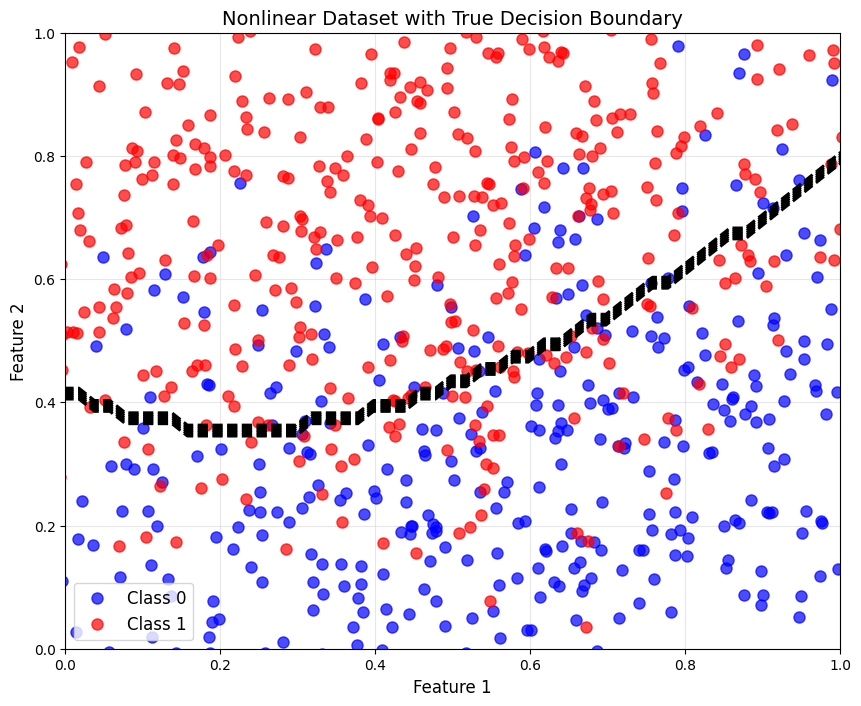


Creating spiral dataset for comparison...
Spiral training: 900 samples
Spiral validation: 450 samples

Visualizing spiral dataset...


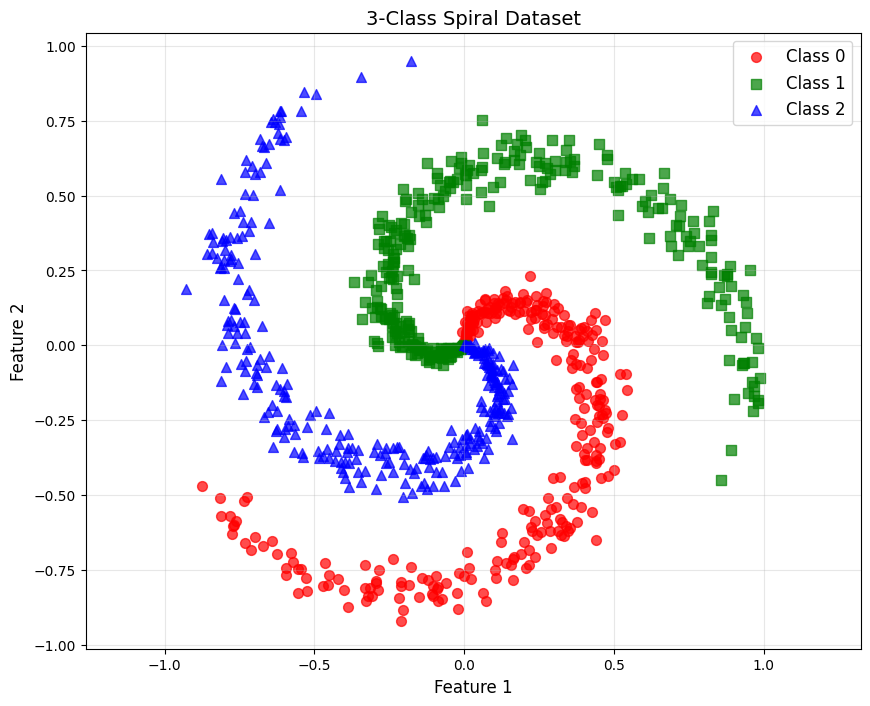

In [11]:
# =============================================================================
# Dataset Creation and Comparison
# =============================================================================

print("=== Creating Datasets for Dropout Experiments ===")

# Create nonlinear dataset for overfitting experiments
torch.manual_seed(42)  # Set seed for reproducibility
train_dataset = NonlinearData(N_SAMPLES=1000, noise_std=0.2, train=True)  # Training data
val_dataset = NonlinearData(N_SAMPLES=500, noise_std=0.2, train=False)  # Validation data

print(f"Training dataset: {len(train_dataset)} samples")
print(f"Validation dataset: {len(val_dataset)} samples")

# Visualize the datasets
print("\nVisualizing training dataset...")
train_dataset.plot_data()

# Also create spiral dataset for comparison
print("\nCreating spiral dataset for comparison...")
spiral_train = SpiralData(K=3, N=300)  # Spiral training data
spiral_val = SpiralData(K=3, N=150)  # Spiral validation data
print(f"Spiral training: {len(spiral_train)} samples")
print(f"Spiral validation: {len(spiral_val)} samples")

print("\nVisualizing spiral dataset...")
spiral_train.plot_data()

=== Experiment 1: Dropout Effects on Nonlinear Dataset ===
Training 4 models with different dropout configurations...
Initialized No Dropout
=== Network Architecture Summary ===
Input Size: 2
Hidden Layers: [300, 300, 300]
Output Size: 2
Dropout Probabilities: [0.0, 0.0, 0.0]
Total Parameters: 182,102

Layer-wise Parameters:
  Hidden Layer 1: 900 parameters, Dropout: 0.0
  Hidden Layer 2: 90,300 parameters, Dropout: 0.0
  Hidden Layer 3: 90,300 parameters, Dropout: 0.0
  Output Layer: 602 parameters

Initialized Light Dropout (0.2)
=== Network Architecture Summary ===
Input Size: 2
Hidden Layers: [300, 300, 300]
Output Size: 2
Dropout Probabilities: [0.2, 0.2, 0.2]
Total Parameters: 182,102

Layer-wise Parameters:
  Hidden Layer 1: 900 parameters, Dropout: 0.2
  Hidden Layer 2: 90,300 parameters, Dropout: 0.2
  Hidden Layer 3: 90,300 parameters, Dropout: 0.2
  Output Layer: 602 parameters

Initialized Medium Dropout (0.5)
=== Network Architecture Summary ===
Input Size: 2
Hidden Layers

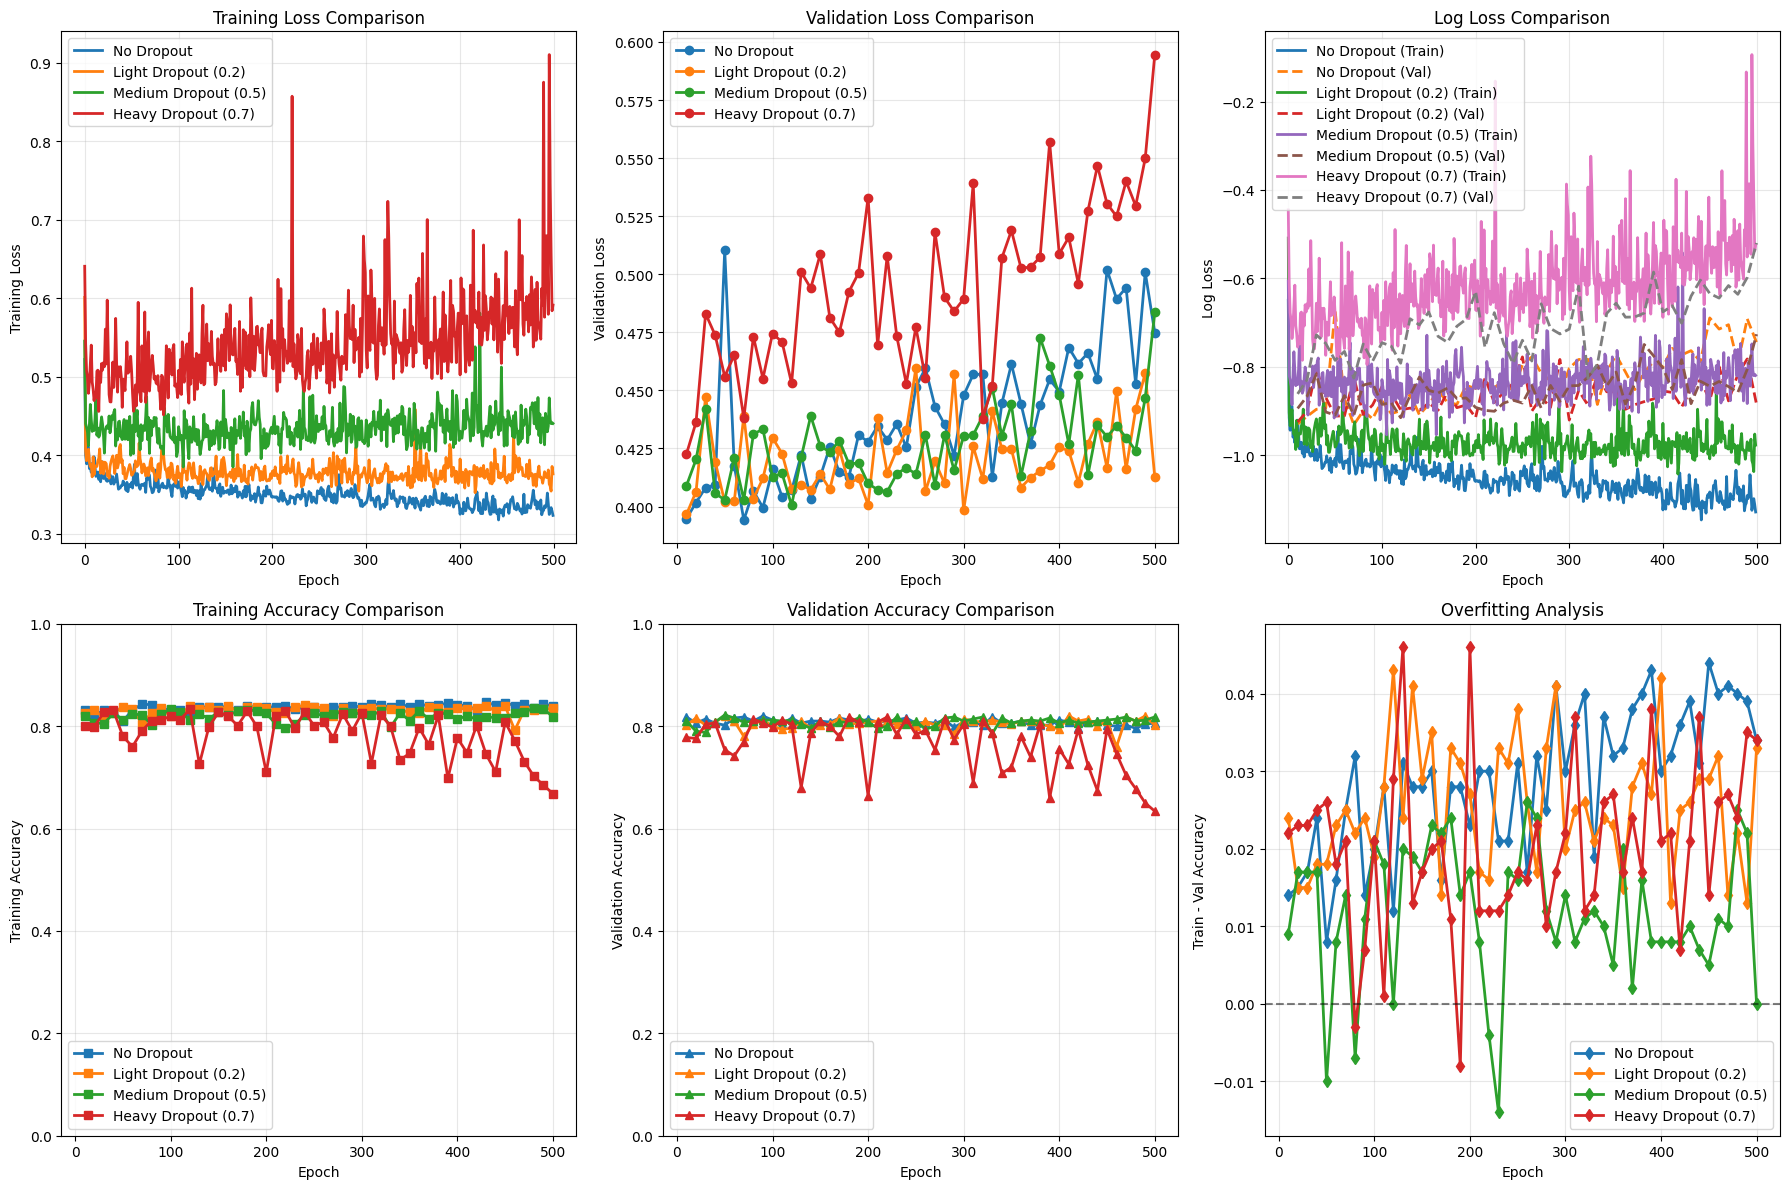

In [12]:
# =============================================================================
# Experiment 1: Dropout Effect on Nonlinear Classification
# =============================================================================

print("=== Experiment 1: Dropout Effects on Nonlinear Dataset ===")

# Define model configurations with different dropout rates
models_config_nonlinear = [
    {
        'name': 'No Dropout',
        'input_size': 2,
        'hidden_sizes': [300, 300, 300],  # Deep network prone to overfitting
        'output_size': 2,
        'dropout_probs': [0.0, 0.0, 0.0]  # No dropout
    },
    {
        'name': 'Light Dropout (0.2)',
        'input_size': 2,
        'hidden_sizes': [300, 300, 300],
        'output_size': 2,
        'dropout_probs': [0.2, 0.2, 0.2]  # Light dropout
    },
    {
        'name': 'Medium Dropout (0.5)',
        'input_size': 2,
        'hidden_sizes': [300, 300, 300],
        'output_size': 2,
        'dropout_probs': [0.5, 0.5, 0.5]  # Medium dropout
    },
    {
        'name': 'Heavy Dropout (0.7)',
        'input_size': 2,
        'hidden_sizes': [300, 300, 300],
        'output_size': 2,
        'dropout_probs': [0.7, 0.7, 0.7]  # Heavy dropout
    }
]

# Train models with different dropout rates
models_nonlinear, loss_hist_nonlinear, acc_hist_nonlinear = train_with_dropout_analysis(
    train_dataset, val_dataset, models_config_nonlinear, 
    epochs=500, batch_size=32, learning_rate=0.01, device=device
)

# Plot comparison results
print("\nGenerating dropout comparison plots...")
plot_dropout_comparison(loss_hist_nonlinear, acc_hist_nonlinear)

=== Experiment 2: Dropout Effects on Spiral Dataset ===
Training 3 models with different dropout configurations...
Initialized Spiral No Dropout
=== Network Architecture Summary ===
Input Size: 2
Hidden Layers: [100, 100, 100]
Output Size: 3
Dropout Probabilities: [0.0, 0.0, 0.0]
Total Parameters: 20,803

Layer-wise Parameters:
  Hidden Layer 1: 300 parameters, Dropout: 0.0
  Hidden Layer 2: 10,100 parameters, Dropout: 0.0
  Hidden Layer 3: 10,100 parameters, Dropout: 0.0
  Output Layer: 303 parameters

Initialized Spiral Dropout (0.3)
=== Network Architecture Summary ===
Input Size: 2
Hidden Layers: [100, 100, 100]
Output Size: 3
Dropout Probabilities: [0.3, 0.3, 0.3]
Total Parameters: 20,803

Layer-wise Parameters:
  Hidden Layer 1: 300 parameters, Dropout: 0.3
  Hidden Layer 2: 10,100 parameters, Dropout: 0.3
  Hidden Layer 3: 10,100 parameters, Dropout: 0.3
  Output Layer: 303 parameters

Initialized Spiral Dropout (0.6)
=== Network Architecture Summary ===
Input Size: 2
Hidden Lay

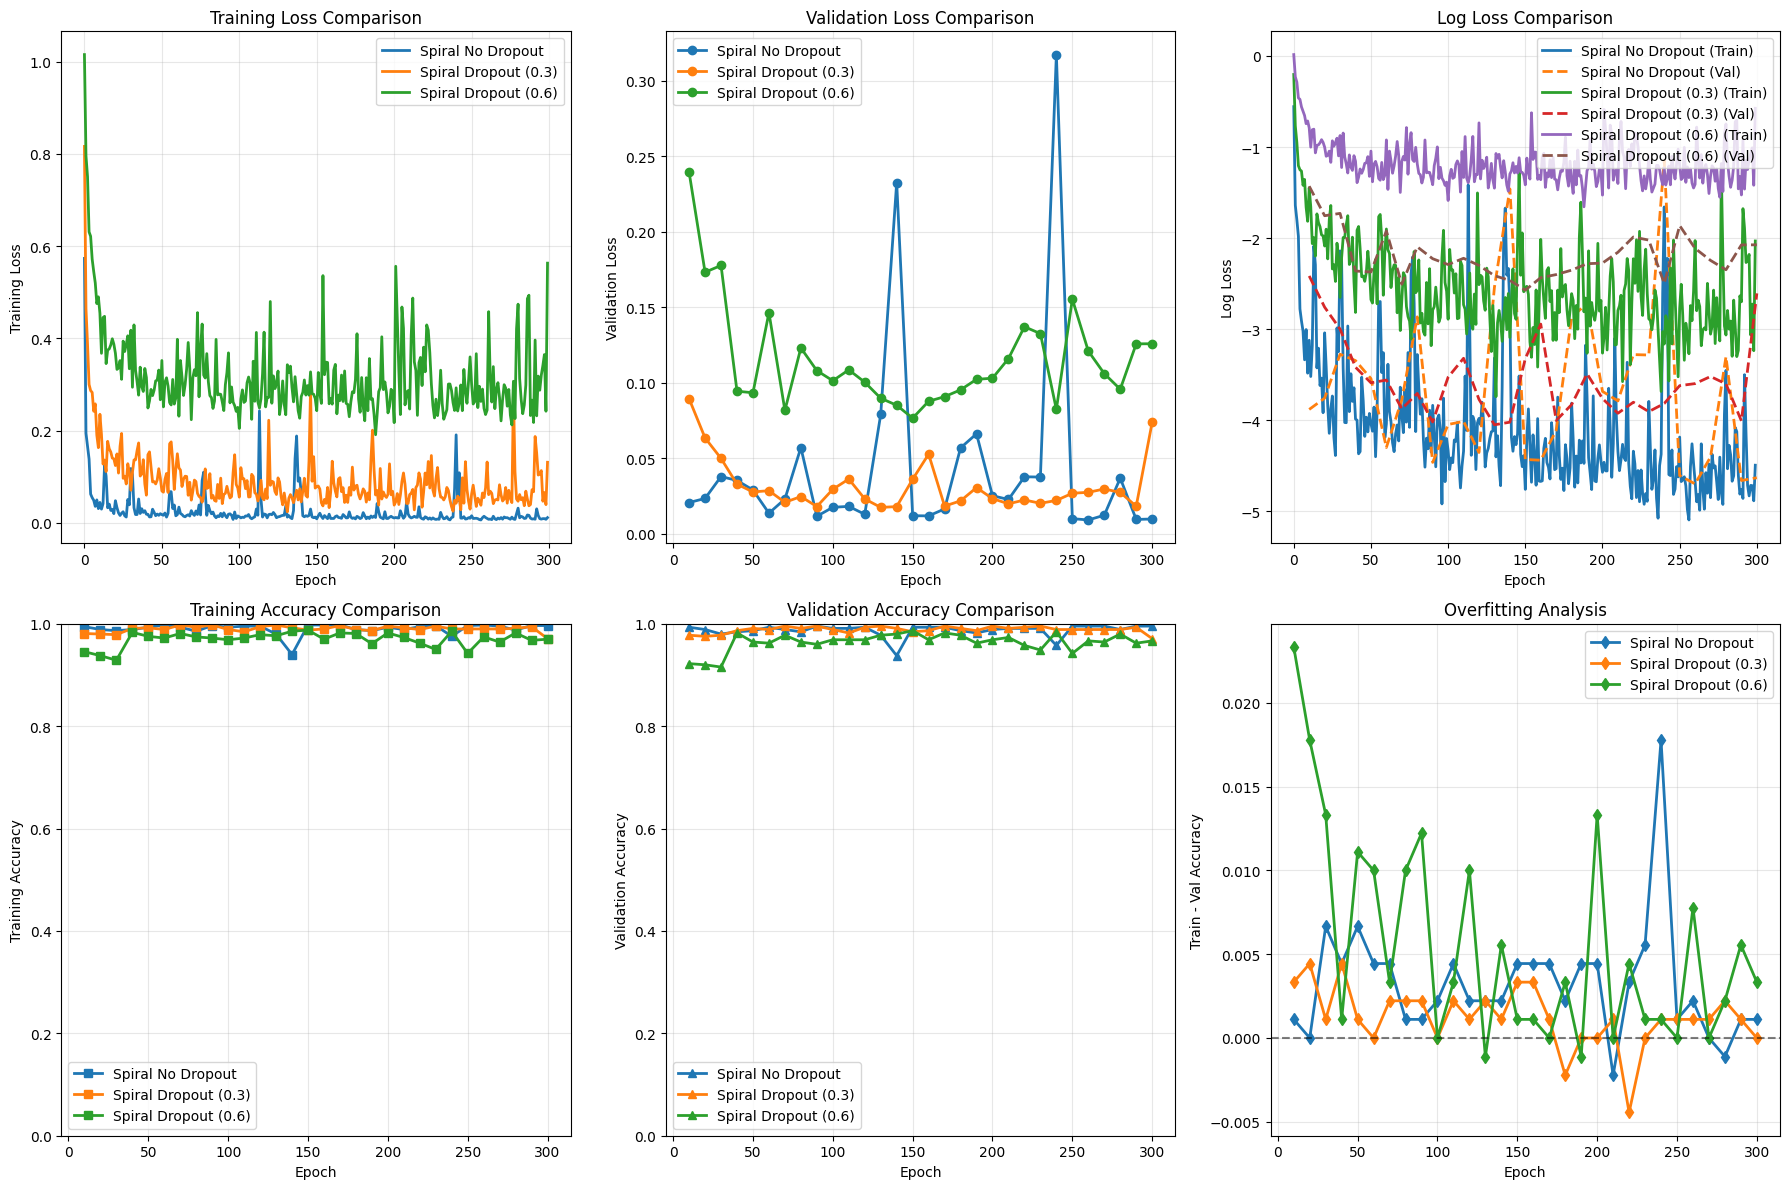

In [13]:
# =============================================================================
# Experiment 2: Dropout Effect on Spiral Classification
# =============================================================================

print("=== Experiment 2: Dropout Effects on Spiral Dataset ===")

# Define model configurations for spiral dataset (3-class)
models_config_spiral = [
    {
        'name': 'Spiral No Dropout',
        'input_size': 2,
        'hidden_sizes': [100, 100, 100],  # Moderate complexity
        'output_size': 3,  # 3 classes for spiral
        'dropout_probs': [0.0, 0.0, 0.0]  # No dropout
    },
    {
        'name': 'Spiral Dropout (0.3)',
        'input_size': 2,
        'hidden_sizes': [100, 100, 100],
        'output_size': 3,
        'dropout_probs': [0.3, 0.3, 0.3]  # Moderate dropout
    },
    {
        'name': 'Spiral Dropout (0.6)',
        'input_size': 2,
        'hidden_sizes': [100, 100, 100],
        'output_size': 3,
        'dropout_probs': [0.6, 0.6, 0.6]  # High dropout
    }
]

# Train models on spiral dataset
models_spiral, loss_hist_spiral, acc_hist_spiral = train_with_dropout_analysis(
    spiral_train, spiral_val, models_config_spiral, 
    epochs=300, batch_size=20, learning_rate=0.01, device=device
)

# Plot spiral comparison results
print("\nGenerating spiral dropout comparison plots...")
plot_dropout_comparison(loss_hist_spiral, acc_hist_spiral)


=== Decision Boundary Analysis: Nonlinear Dataset ===


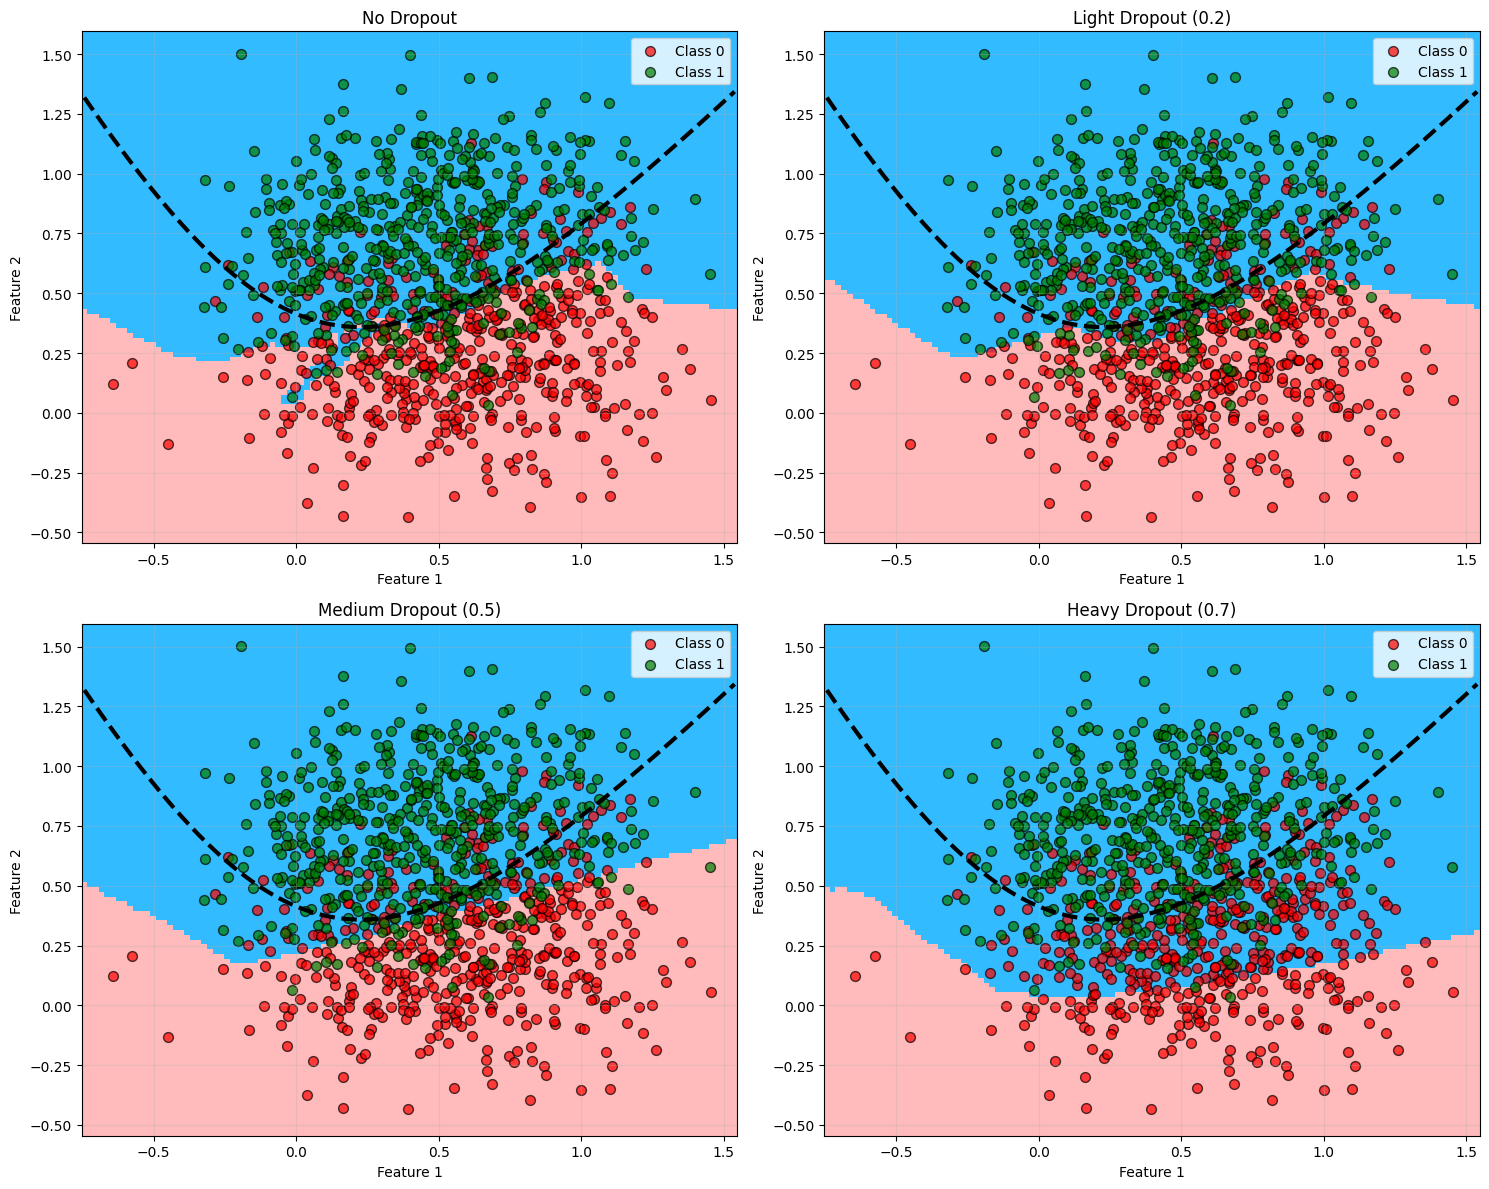

=== Decision Boundary Analysis: Spiral Dataset ===


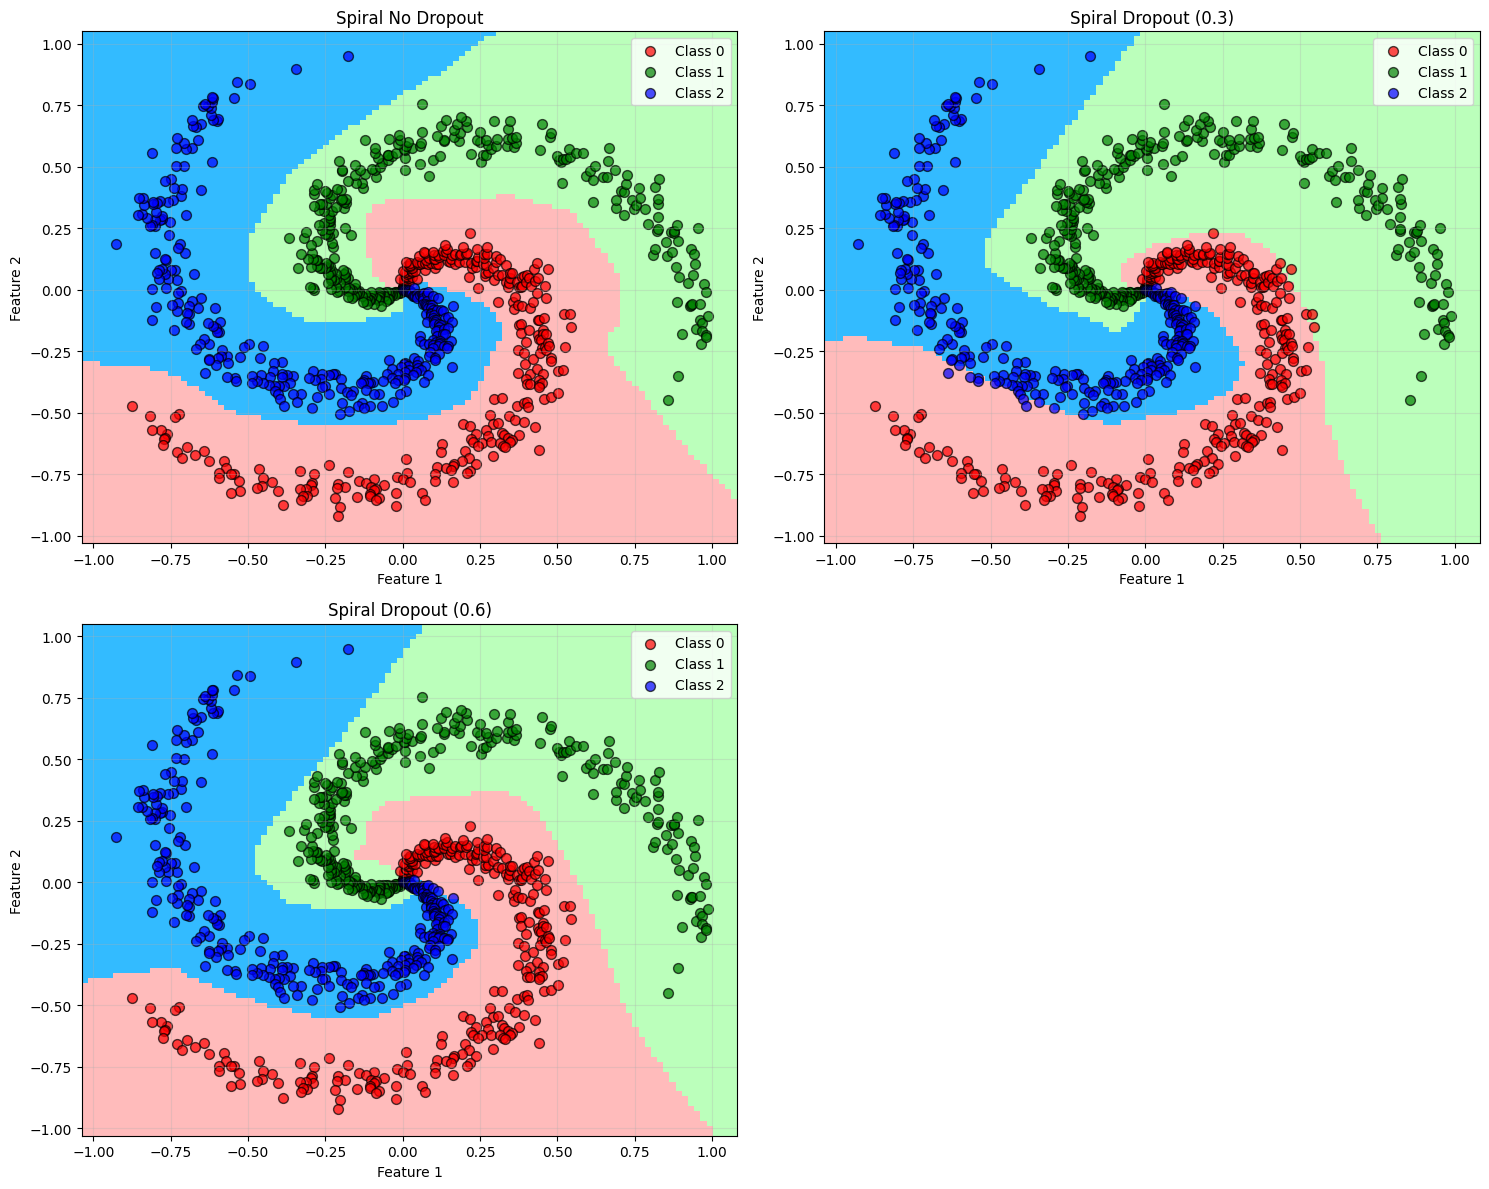

In [14]:
# =============================================================================
# Advanced Decision Boundary Visualization
# =============================================================================

def plot_decision_boundaries_dropout(dataset, models, device=device):  # Function to visualize decision boundaries
    """Plot decision boundaries for models with different dropout rates"""
    
    num_models = len(models)  # Number of models to plot
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # Create subplot grid
    axes = axes.ravel()  # Flatten axes array
    
    # Define colormaps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])  # Light colors for regions
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])  # Bold colors for points
    
    for idx, (name, model) in enumerate(models.items()):  # Plot each model
        if idx >= 4:  # Limit to 4 plots
            break
        
        ax = axes[idx]  # Current subplot
        
        # Get data for plotting
        X = dataset.x.cpu().numpy()  # Features
        y = dataset.y.cpu().numpy()  # Labels
        
        # Create mesh grid
        h = 0.02  # Step size
        x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1  # X bounds
        y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1  # Y bounds
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))  # Mesh grid
        
        # Make predictions on mesh grid
        model.eval()  # Set to evaluation mode
        mesh_points = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)  # Mesh points
        
        with torch.no_grad():  # Disable gradients
            mesh_predictions = model(mesh_points)  # Get predictions
            _, mesh_labels = torch.max(mesh_predictions, 1)  # Get predicted labels
        
        mesh_labels = mesh_labels.cpu().numpy().reshape(xx.shape)  # Reshape predictions
        
        # Plot decision regions
        ax.pcolormesh(xx, yy, mesh_labels, cmap=cmap_light, alpha=0.8)  # Decision regions
        
        # Plot data points
        unique_labels = np.unique(y)  # Get unique labels
        colors = ['red', 'green', 'blue']  # Colors for classes
        for i, label in enumerate(unique_labels):  # Plot each class
            mask = y == label  # Create mask for current class
            ax.scatter(X[mask, 0], X[mask, 1], c=colors[i], 
                      s=50, alpha=0.7, edgecolors='black', label=f'Class {label}')  # Plot points
        
        # If nonlinear dataset, plot true decision boundary
        if hasattr(dataset, 'multi_dim_poly'):  # Check if nonlinear dataset
            Z = dataset.multi_dim_poly(np.c_[xx.ravel(), yy.ravel()]).flatten()  # True boundary
            Z = Z.reshape(xx.shape)  # Reshape
            ax.contour(xx, yy, Z, levels=[0], colors='black', linewidths=3, linestyles='--')  # Plot boundary
        
        ax.set_title(f'{name}', fontsize=12)  # Add title
        ax.set_xlabel('Feature 1')  # X-axis label
        ax.set_ylabel('Feature 2')  # Y-axis label
        ax.legend()  # Add legend
        ax.grid(True, alpha=0.3)  # Add grid
    
    # Hide unused subplots
    for idx in range(num_models, 4):  # Hide remaining subplots
        axes[idx].set_visible(False)  # Hide subplot
    
    plt.tight_layout()  # Adjust layout
    plt.show()  # Display plot

# Visualize decision boundaries for nonlinear dataset
print("=== Decision Boundary Analysis: Nonlinear Dataset ===")
plot_decision_boundaries_dropout(train_dataset, models_nonlinear, device)

# Visualize decision boundaries for spiral dataset
print("=== Decision Boundary Analysis: Spiral Dataset ===")
plot_decision_boundaries_dropout(spiral_train, models_spiral, device)

In [15]:
# =============================================================================
# Comprehensive Analysis and Performance Summary
# =============================================================================

def analyze_dropout_effectiveness(models, loss_history, accuracy_history, dataset_name):  # Function to analyze dropout effectiveness
    """Analyze and summarize dropout effectiveness"""
    
    print(f"\n=== Dropout Effectiveness Analysis: {dataset_name} ===")
    
    # Extract final metrics
    final_results = {}  # Store final results
    for name in models.keys():  # Iterate through models
        final_train_acc = accuracy_history[name]['train'][-1]  # Final training accuracy
        final_val_acc = accuracy_history[name]['val'][-1]  # Final validation accuracy
        overfitting_gap = final_train_acc - final_val_acc  # Overfitting gap
        
        final_results[name] = {
            'train_acc': final_train_acc,
            'val_acc': final_val_acc,
            'overfitting_gap': overfitting_gap,
            'best_val_acc': max(accuracy_history[name]['val'])  # Best validation accuracy
        }
    
    # Display results table
    print(f"{'Model':<25} {'Train Acc':<12} {'Val Acc':<12} {'Gap':<12} {'Best Val':<12}")
    print(f"{'-'*25} {'-'*12} {'-'*12} {'-'*12} {'-'*12}")
    
    for name, results in final_results.items():  # Print results
        print(f"{name:<25} {results['train_acc']:<12.4f} {results['val_acc']:<12.4f} "
              f"{results['overfitting_gap']:<12.4f} {results['best_val_acc']:<12.4f}")
    
    # Find best models
    best_generalization = min(final_results, key=lambda x: final_results[x]['overfitting_gap'])  # Best generalization
    best_validation = max(final_results, key=lambda x: final_results[x]['val_acc'])  # Best validation
    
    print(f"\nKey Insights:")
    print(f"• Best Generalization (lowest gap): {best_generalization}")
    print(f"• Best Validation Performance: {best_validation}")
    
    # Convergence analysis
    print(f"\nConvergence Analysis:")
    threshold = 0.8  # Convergence threshold
    for name, accuracies in accuracy_history.items():  # Analyze convergence
        val_accs = accuracies['val']  # Validation accuracies
        convergence_epoch = next((i * 10 for i, acc in enumerate(val_accs) if acc >= threshold), "Not reached")
        print(f"  {name}: Reached 80% validation accuracy at epoch {convergence_epoch}")
    
    return final_results  # Return results

# Analyze nonlinear dataset results
nonlinear_results = analyze_dropout_effectiveness(
    models_nonlinear, loss_hist_nonlinear, acc_hist_nonlinear, "Nonlinear Dataset"
)

# Analyze spiral dataset results
spiral_results = analyze_dropout_effectiveness(
    models_spiral, loss_hist_spiral, acc_hist_spiral, "Spiral Dataset"
)


=== Dropout Effectiveness Analysis: Nonlinear Dataset ===
Model                     Train Acc    Val Acc      Gap          Best Val    
------------------------- ------------ ------------ ------------ ------------
No Dropout                0.8400       0.8060       0.0340       0.8200      
Light Dropout (0.2)       0.8350       0.8020       0.0330       0.8200      
Medium Dropout (0.5)      0.8180       0.8180       0.0000       0.8220      
Heavy Dropout (0.7)       0.6680       0.6340       0.0340       0.8180      

Key Insights:
• Best Generalization (lowest gap): Medium Dropout (0.5)
• Best Validation Performance: Medium Dropout (0.5)

Convergence Analysis:
  No Dropout: Reached 80% validation accuracy at epoch 0
  Light Dropout (0.2): Reached 80% validation accuracy at epoch 0
  Medium Dropout (0.5): Reached 80% validation accuracy at epoch 0
  Heavy Dropout (0.7): Reached 80% validation accuracy at epoch 20

=== Dropout Effectiveness Analysis: Spiral Dataset ===
Model        

In [16]:
# =============================================================================
# Advanced Dropout Strategies and Recommendations
# =============================================================================

print(f"\n=== Advanced Dropout Insights and Recommendations ===")

print(f"\nDropout Mechanisms:")
print(f"• During Training: Randomly sets neurons to 0 with probability p")
print(f"• During Inference: All neurons active, outputs scaled by (1-p)")
print(f"• Forces network to learn redundant representations")
print(f"• Prevents co-adaptation of neurons")

print(f"\nOptimal Dropout Rates by Layer Type:")
print(f"• Input layers: 0.1 - 0.2 (light dropout)")
print(f"• Hidden layers: 0.3 - 0.7 (moderate to heavy)")
print(f"• Output layers: No dropout (preserves final predictions)")

print(f"\nDropout vs Network Depth:")
print(f"• Shallow networks: Lower dropout rates (0.2 - 0.4)")
print(f"• Deep networks: Higher dropout rates (0.5 - 0.7)")
print(f"• Very deep networks: Combine with batch normalization")

print(f"\nDataset-Specific Observations:")
print(f"• Small datasets: Higher dropout rates prevent overfitting")
print(f"• Large datasets: Lower dropout rates maintain capacity")
print(f"• Complex patterns: Moderate dropout preserves learning ability")

print(f"\nAlternative Regularization Techniques:")
print(f"• Batch Normalization: Stabilizes training, implicit regularization")
print(f"• Layer Normalization: Good for RNNs and transformers")
print(f"• Weight Decay (L2): Penalizes large weights")
print(f"• Early Stopping: Prevents overfitting during training")

print(f"\nBest Practices for Dropout:")
print(f"• Start with moderate rates (0.3-0.5) and adjust based on validation")
print(f"• Use higher rates for larger, more complex networks")
print(f"• Apply different rates to different layers")
print(f"• Monitor training vs validation performance closely")
print(f"• Combine with other regularization techniques for best results")

print(f"\nGPU Acceleration Benefits:")
if device.type == 'cuda':
    print(f"• Dropout computations accelerated on: {torch.cuda.get_device_name(0)}")
    print(f"• Random number generation optimized for CUDA")
    print(f"• Large batch processing enables efficient dropout sampling")
else:
    print(f"• CPU training completed - GPU would accelerate larger experiments")
    print(f"• Consider GPU for training very deep networks with dropout")

print(f"\nConclusion:")
print(f"• Dropout is essential for preventing overfitting in deep networks")
print(f"• Optimal dropout rate depends on architecture and dataset complexity")
print(f"• Proper dropout leads to better generalization and robustness")
print(f"• Monitor both training and validation metrics to tune dropout effectively")


=== Advanced Dropout Insights and Recommendations ===

Dropout Mechanisms:
• During Training: Randomly sets neurons to 0 with probability p
• During Inference: All neurons active, outputs scaled by (1-p)
• Forces network to learn redundant representations
• Prevents co-adaptation of neurons

Optimal Dropout Rates by Layer Type:
• Input layers: 0.1 - 0.2 (light dropout)
• Hidden layers: 0.3 - 0.7 (moderate to heavy)
• Output layers: No dropout (preserves final predictions)

Dropout vs Network Depth:
• Shallow networks: Lower dropout rates (0.2 - 0.4)
• Deep networks: Higher dropout rates (0.5 - 0.7)
• Very deep networks: Combine with batch normalization

Dataset-Specific Observations:
• Small datasets: Higher dropout rates prevent overfitting
• Large datasets: Lower dropout rates maintain capacity
• Complex patterns: Moderate dropout preserves learning ability

Alternative Regularization Techniques:
• Batch Normalization: Stabilizes training, implicit regularization
• Layer Normalizati

=== Experiment 3: Adaptive Dropout Strategy ===
Training 2 models with different dropout configurations...
Initialized Adaptive Dropout
=== Network Architecture Summary ===
Input Size: 2
Hidden Layers: [200, 150, 100, 50]
Output Size: 2
Dropout Probabilities: [0.2, 0.3, 0.5, 0.6]
Total Parameters: 51,002

Layer-wise Parameters:
  Hidden Layer 1: 600 parameters, Dropout: 0.2
  Hidden Layer 2: 30,150 parameters, Dropout: 0.3
  Hidden Layer 3: 15,100 parameters, Dropout: 0.5
  Hidden Layer 4: 5,050 parameters, Dropout: 0.6
  Output Layer: 102 parameters

Initialized Uniform Dropout
=== Network Architecture Summary ===
Input Size: 2
Hidden Layers: [200, 150, 100, 50]
Output Size: 2
Dropout Probabilities: [0.4, 0.4, 0.4, 0.4]
Total Parameters: 51,002

Layer-wise Parameters:
  Hidden Layer 1: 600 parameters, Dropout: 0.4
  Hidden Layer 2: 30,150 parameters, Dropout: 0.4
  Hidden Layer 3: 15,100 parameters, Dropout: 0.4
  Hidden Layer 4: 5,050 parameters, Dropout: 0.4
  Output Layer: 102 para

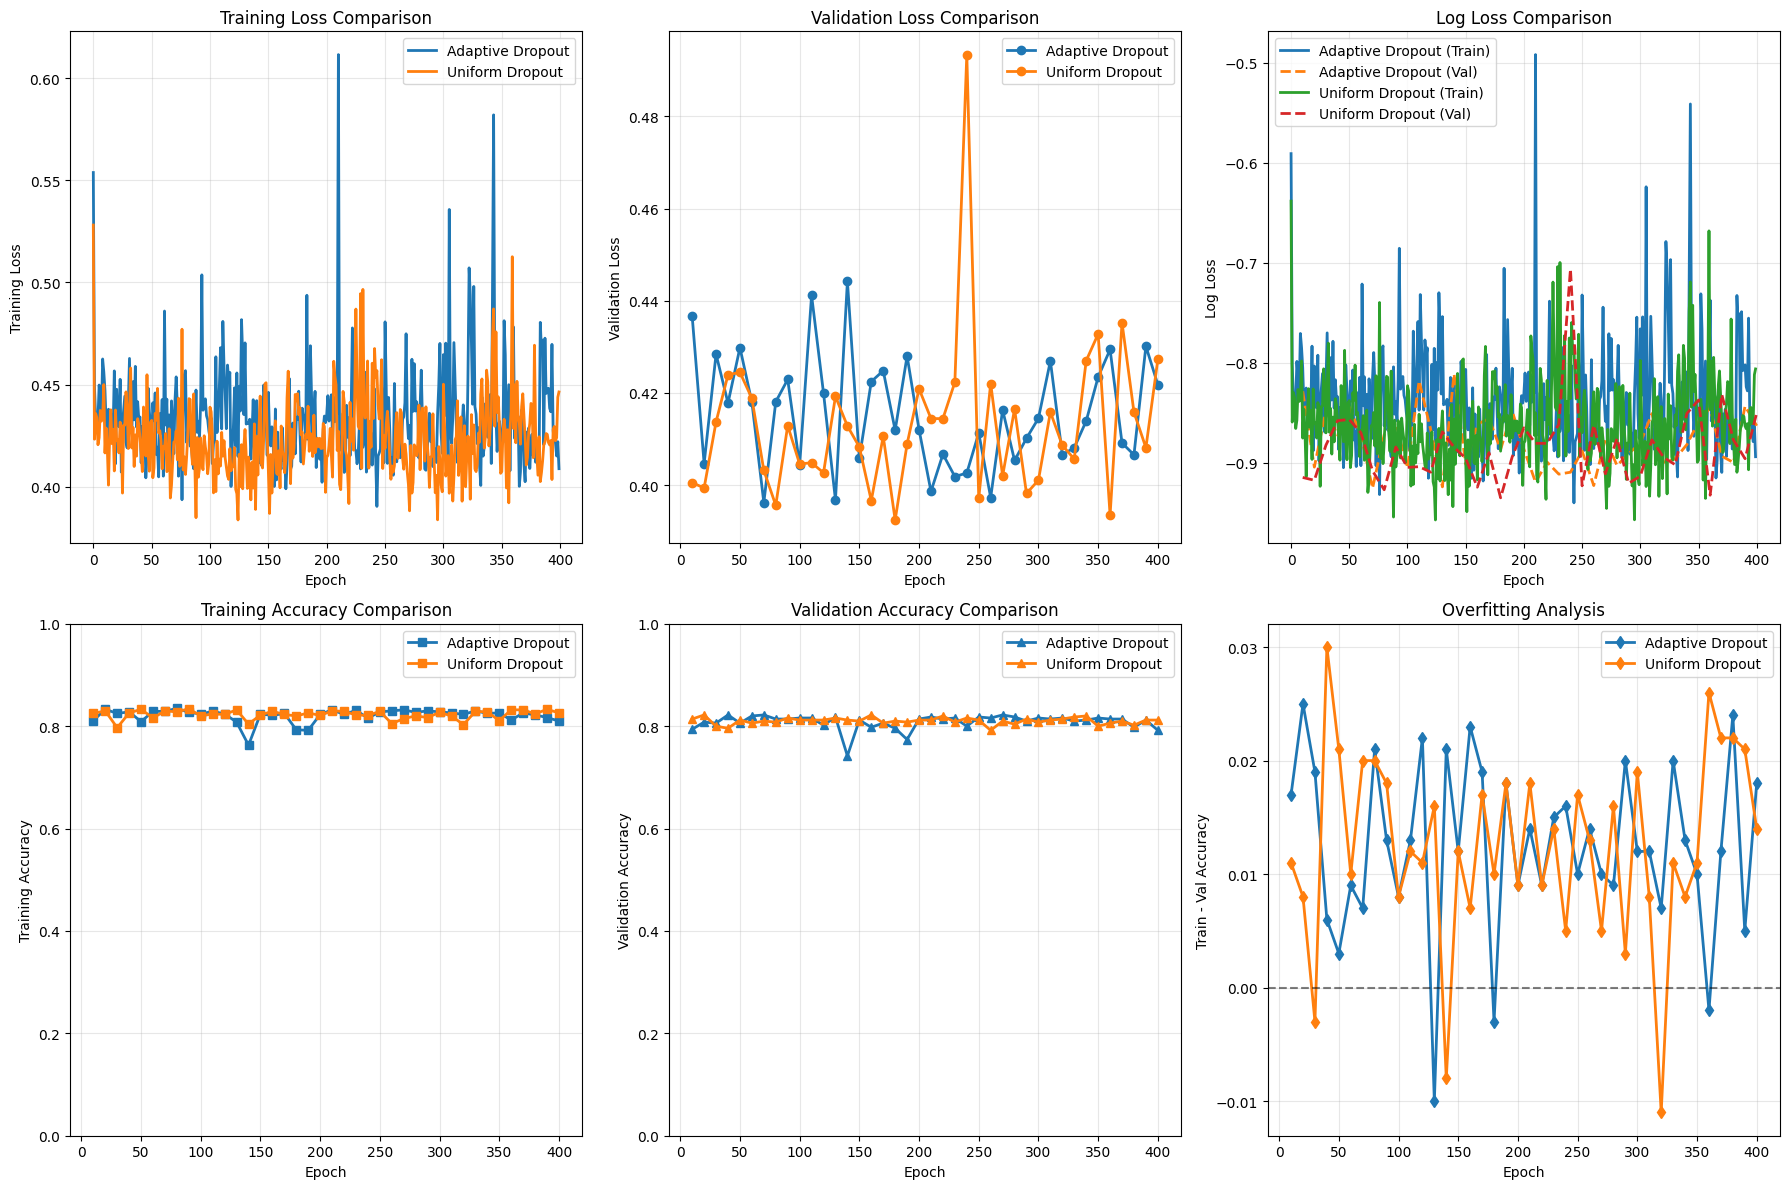

In [17]:
# =============================================================================
# Experiment 3: Adaptive Dropout Strategy
# =============================================================================

print("=== Experiment 3: Adaptive Dropout Strategy ===")

# Define adaptive dropout configuration
adaptive_config = [
    {
        'name': 'Adaptive Dropout',
        'input_size': 2,
        'hidden_sizes': [200, 150, 100, 50],  # Decreasing layer sizes
        'output_size': 2,
        'dropout_probs': [0.2, 0.3, 0.5, 0.6]  # Increasing dropout rates
    },
    {
        'name': 'Uniform Dropout',
        'input_size': 2,
        'hidden_sizes': [200, 150, 100, 50],
        'output_size': 2,
        'dropout_probs': [0.4, 0.4, 0.4, 0.4]  # Uniform dropout rates
    }
]

# Train adaptive dropout models
models_adaptive, loss_hist_adaptive, acc_hist_adaptive = train_with_dropout_analysis(
    train_dataset, val_dataset, adaptive_config, 
    epochs=400, batch_size=32, learning_rate=0.01, device=device
)

# Analyze adaptive dropout results
adaptive_results = analyze_dropout_effectiveness(
    models_adaptive, loss_hist_adaptive, acc_hist_adaptive, "Adaptive Dropout Strategy"
)

print(f"\nAdaptive Dropout Strategy Benefits:")
print(f"• Early layers: Light dropout preserves input information")
print(f"• Later layers: Heavy dropout prevents overspecialization")
print(f"• Gradual increase: Balances feature extraction and generalization")
print(f"• Architecture-aware: Dropout rates match layer responsibilities")

# Final visualization
print("\nGenerating final adaptive dropout comparison...")
plot_dropout_comparison(loss_hist_adaptive, acc_hist_adaptive)